In [1]:
#dependencies
import os
import h5py
import pylab as pl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy

import utils.conversions as cnv
import utils.plotutils as plu
import utils.movie_plotutils as mplu
import utils.imreadin as imr
import utils.readMov as rdm
import utils.movie_aec as aec
import utils.train_model as tm

import imp
imp.reload(rdm)
imp.reload(tm)
imp.reload(cnv)
imp.reload(mplu)
from random import shuffle

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 500} #plotting pretty

/home/vasha/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [78]:
imp.reload(rdm)
movie_name = 'snow_monkeys' #'snow_monkeys' #
pixelpatchsize = 10
framepatchsize = 4

colorinvert = False

#m = imr.load_images('vh_corr', patch_edge_size=8)
#del m
with tf.device('/cpu:0'):
    try:
        m
        print('Movie Already Loaded.')
    except NameError:
        m = rdm.get_movie(movie_name,
                          pixel_patch_size = pixelpatchsize,
                          frame_patch_size = framepatchsize
                          )
        #m = np.transpose(m, (0, 3, 1, 2)) #change axis to [batchsize, time_patchsize, x_patchsize, y_patchsize]

        print("Movie Loaded. Shape is " + str(np.shape(m)))
        
        #only make anew dict and change these in params dict if we have reloaded images.
        params = {} #make a new dictionary
        #fill up our new dictionary
        params["movie_name"] = movie_name
        params['nmovies'] = np.shape(m)[0]
        params["pixelpatchsize"] = pixelpatchsize
        params["framepatchsize"] = framepatchsize
print("Done")

(120, 676, 1280)
normalizing movie...
making patches...
(257280, 10, 10, 4)
Movie Loaded. Shape is (257280, 4, 10, 10)
Done


In [6]:
#fixed parameters
params['frames_per_channel'] = params["framepatchsize"]  #OR convolution window (number of frames that project on one channel)
params['clipvec_len'] = params['frames_per_channel']*params['pixelpatchsize']*params['pixelpatchsize']

params["batchsize"] = 10000
params["learning_rate"] = 0.03

params["iterations"] = np.int(np.floor(params["nmovies"]/params["batchsize"]))
params["epochs"] = 50


params['nonlinearity'] = 'relu'

params['nneurons'] = 48
#pixelpatchsize**2 * framepatchsize

#params for sweeping
noise_xs_rs_pairs = [[0.,0.]] #, [1e-1, 5], [1e-1, 2], [1e-1, 3.5], [1e-3,5e-1]]


#check to make sure our training numbers are consistent with our dataset
params["moviesperepoch"] = params["iterations"] *params["batchsize"]
if(params["moviesperepoch"] > params['nmovies']):
    print('ERROR! Trying to train on', params["moviesperepoch"],'movies per epoch, but we only have',params['nmovies'],'movie clips!')
else:
    print('Training',params["moviesperepoch"],'out of',params["nmovies"],'total movies.')
    
print('Compression Level: {}'.format((params["pixelpatchsize"]**2*params['frames_per_channel'])/params["nneurons"]))

Training 220000 out of 222976 total movies.
Compression Level: 8.333333333333334


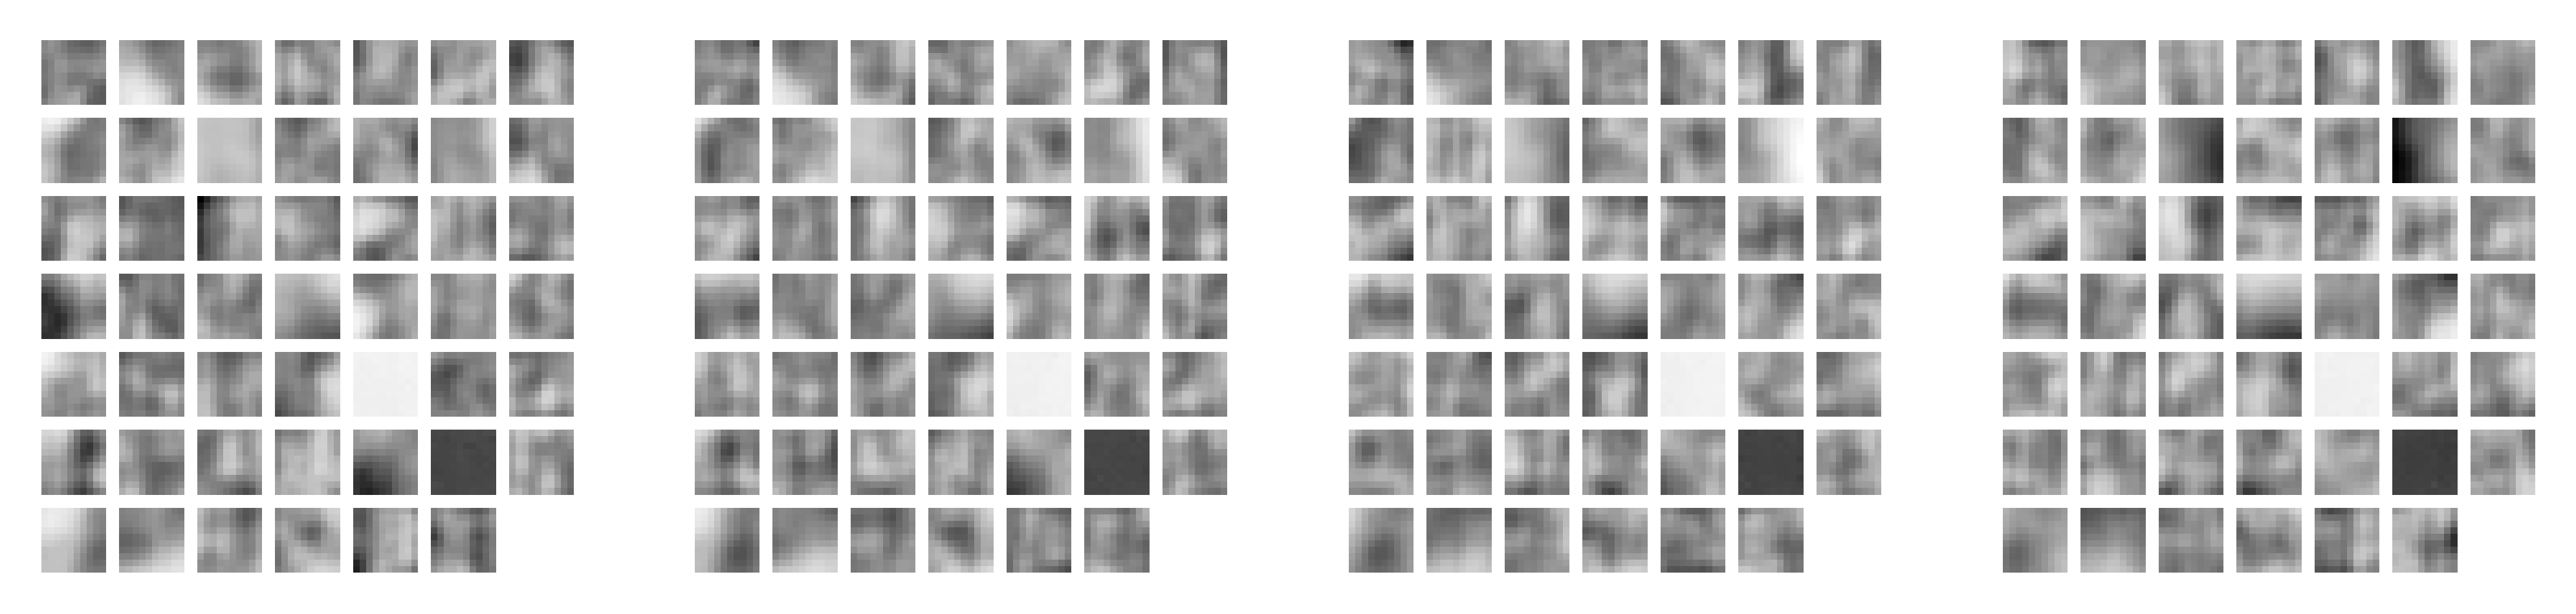

Epoch 46/50 Epoch 47/50 Epoch 48/50 Epoch 49/50 Done calculating!
All Done!


In [9]:
#reload
imp.reload(aec)
imp.reload(tm)
imp.reload(mplu)
imp.reload(plu)

for xs,rs in noise_xs_rs_pairs:
    params['noise_x'] = xs
    params['noise_r'] = rs

    #make our model
    aecmodel = aec.movie_aec_model(params)

    #train it
    [cost_evolution,
     activation_evolution,
     inweights_evolution,
     outweights_evolution,
     clips,
     recons,
     final_inweights,
     final_outweights,
     final_activations] = tm.train_movie_model(aecmodel, m)

    #mplu.save_plots(aecmodel,
    #                cost_evolution,
    #                activation_evolution,
    #                inweights_evolution,
    #                outweights_evolution,
    #                clips,
    #                recons,
    #                final_inweights,
    #                final_outweights,
    #                final_activations)

    print('All Done!')

In [10]:
print(final_inweights.shape)
print(final_outweights.shape)

(4, 10, 10, 48)
(48, 10, 10, 4)


(array([  24.,  528.,  693., 2606., 5773., 5783., 2570.,  643.,  147.,
         433.]),
 array([-0.0575943 , -0.04611097, -0.03462764, -0.02314432, -0.01166099,
        -0.00017766,  0.01130566,  0.02278899,  0.03427232,  0.04575564,
         0.05723897]),
 <a list of 10 Patch objects>)

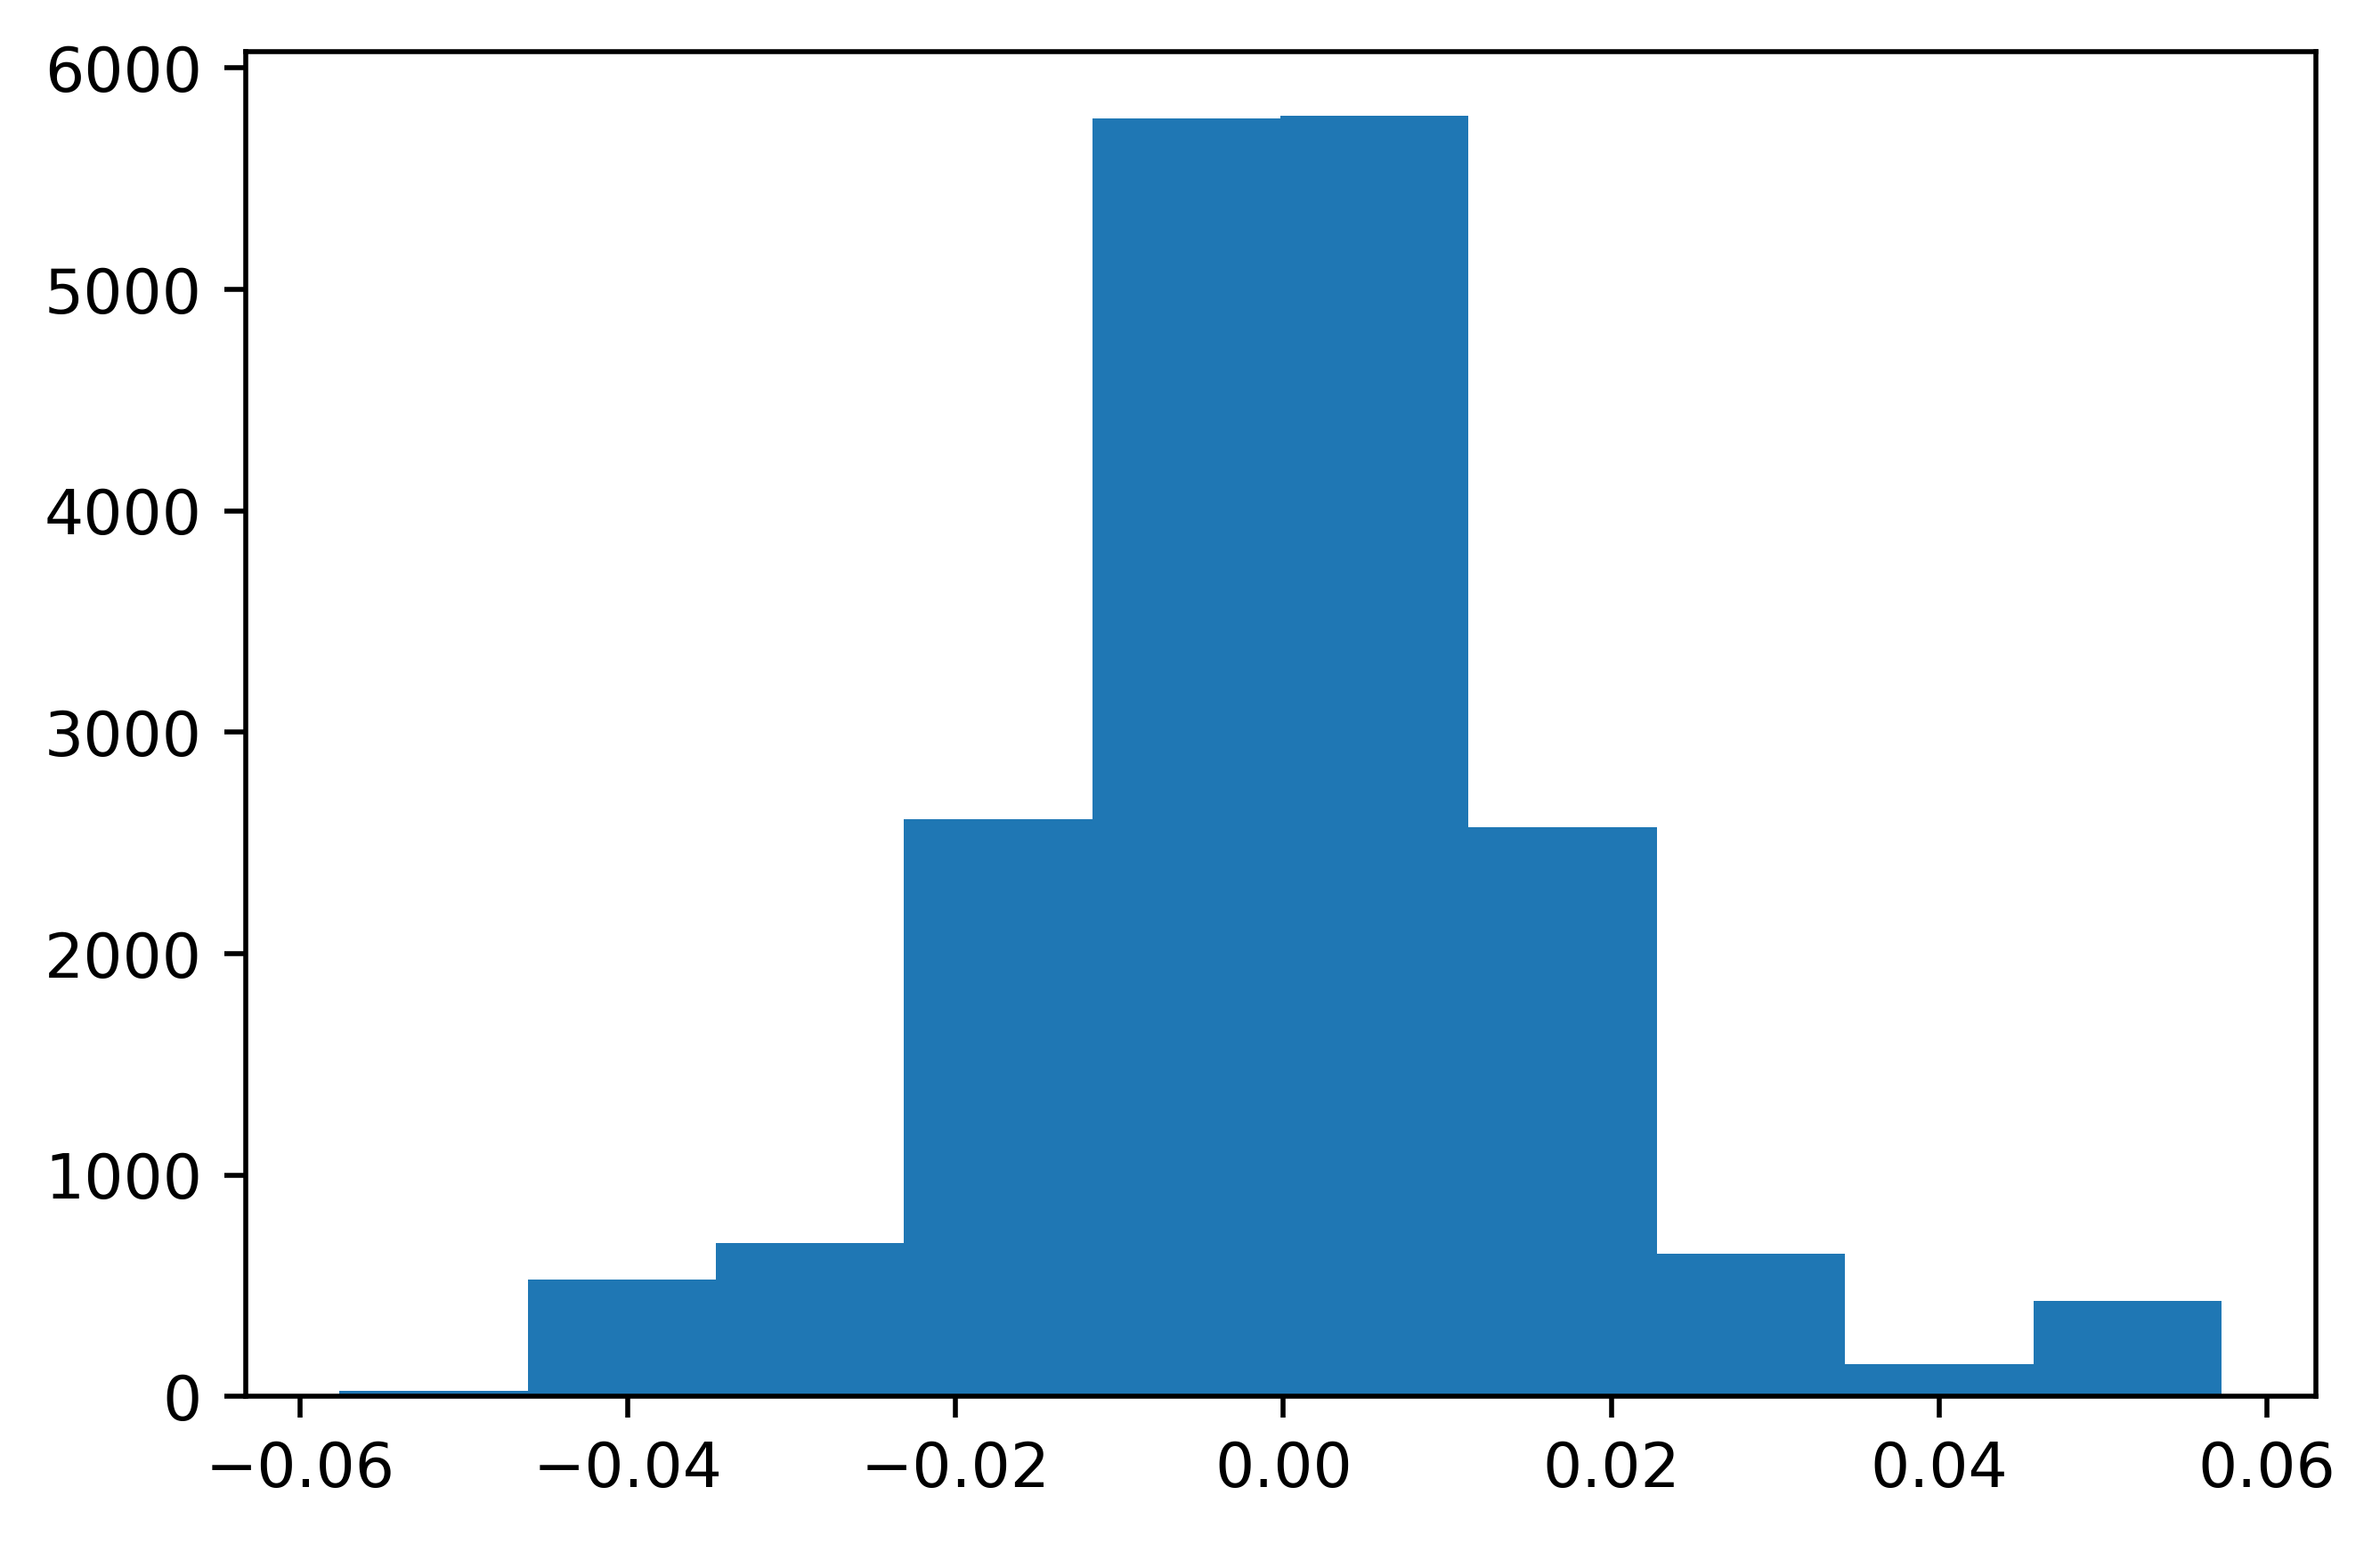

In [12]:
plt.hist(final_outweights.flatten())

(48, 10, 10, 4)


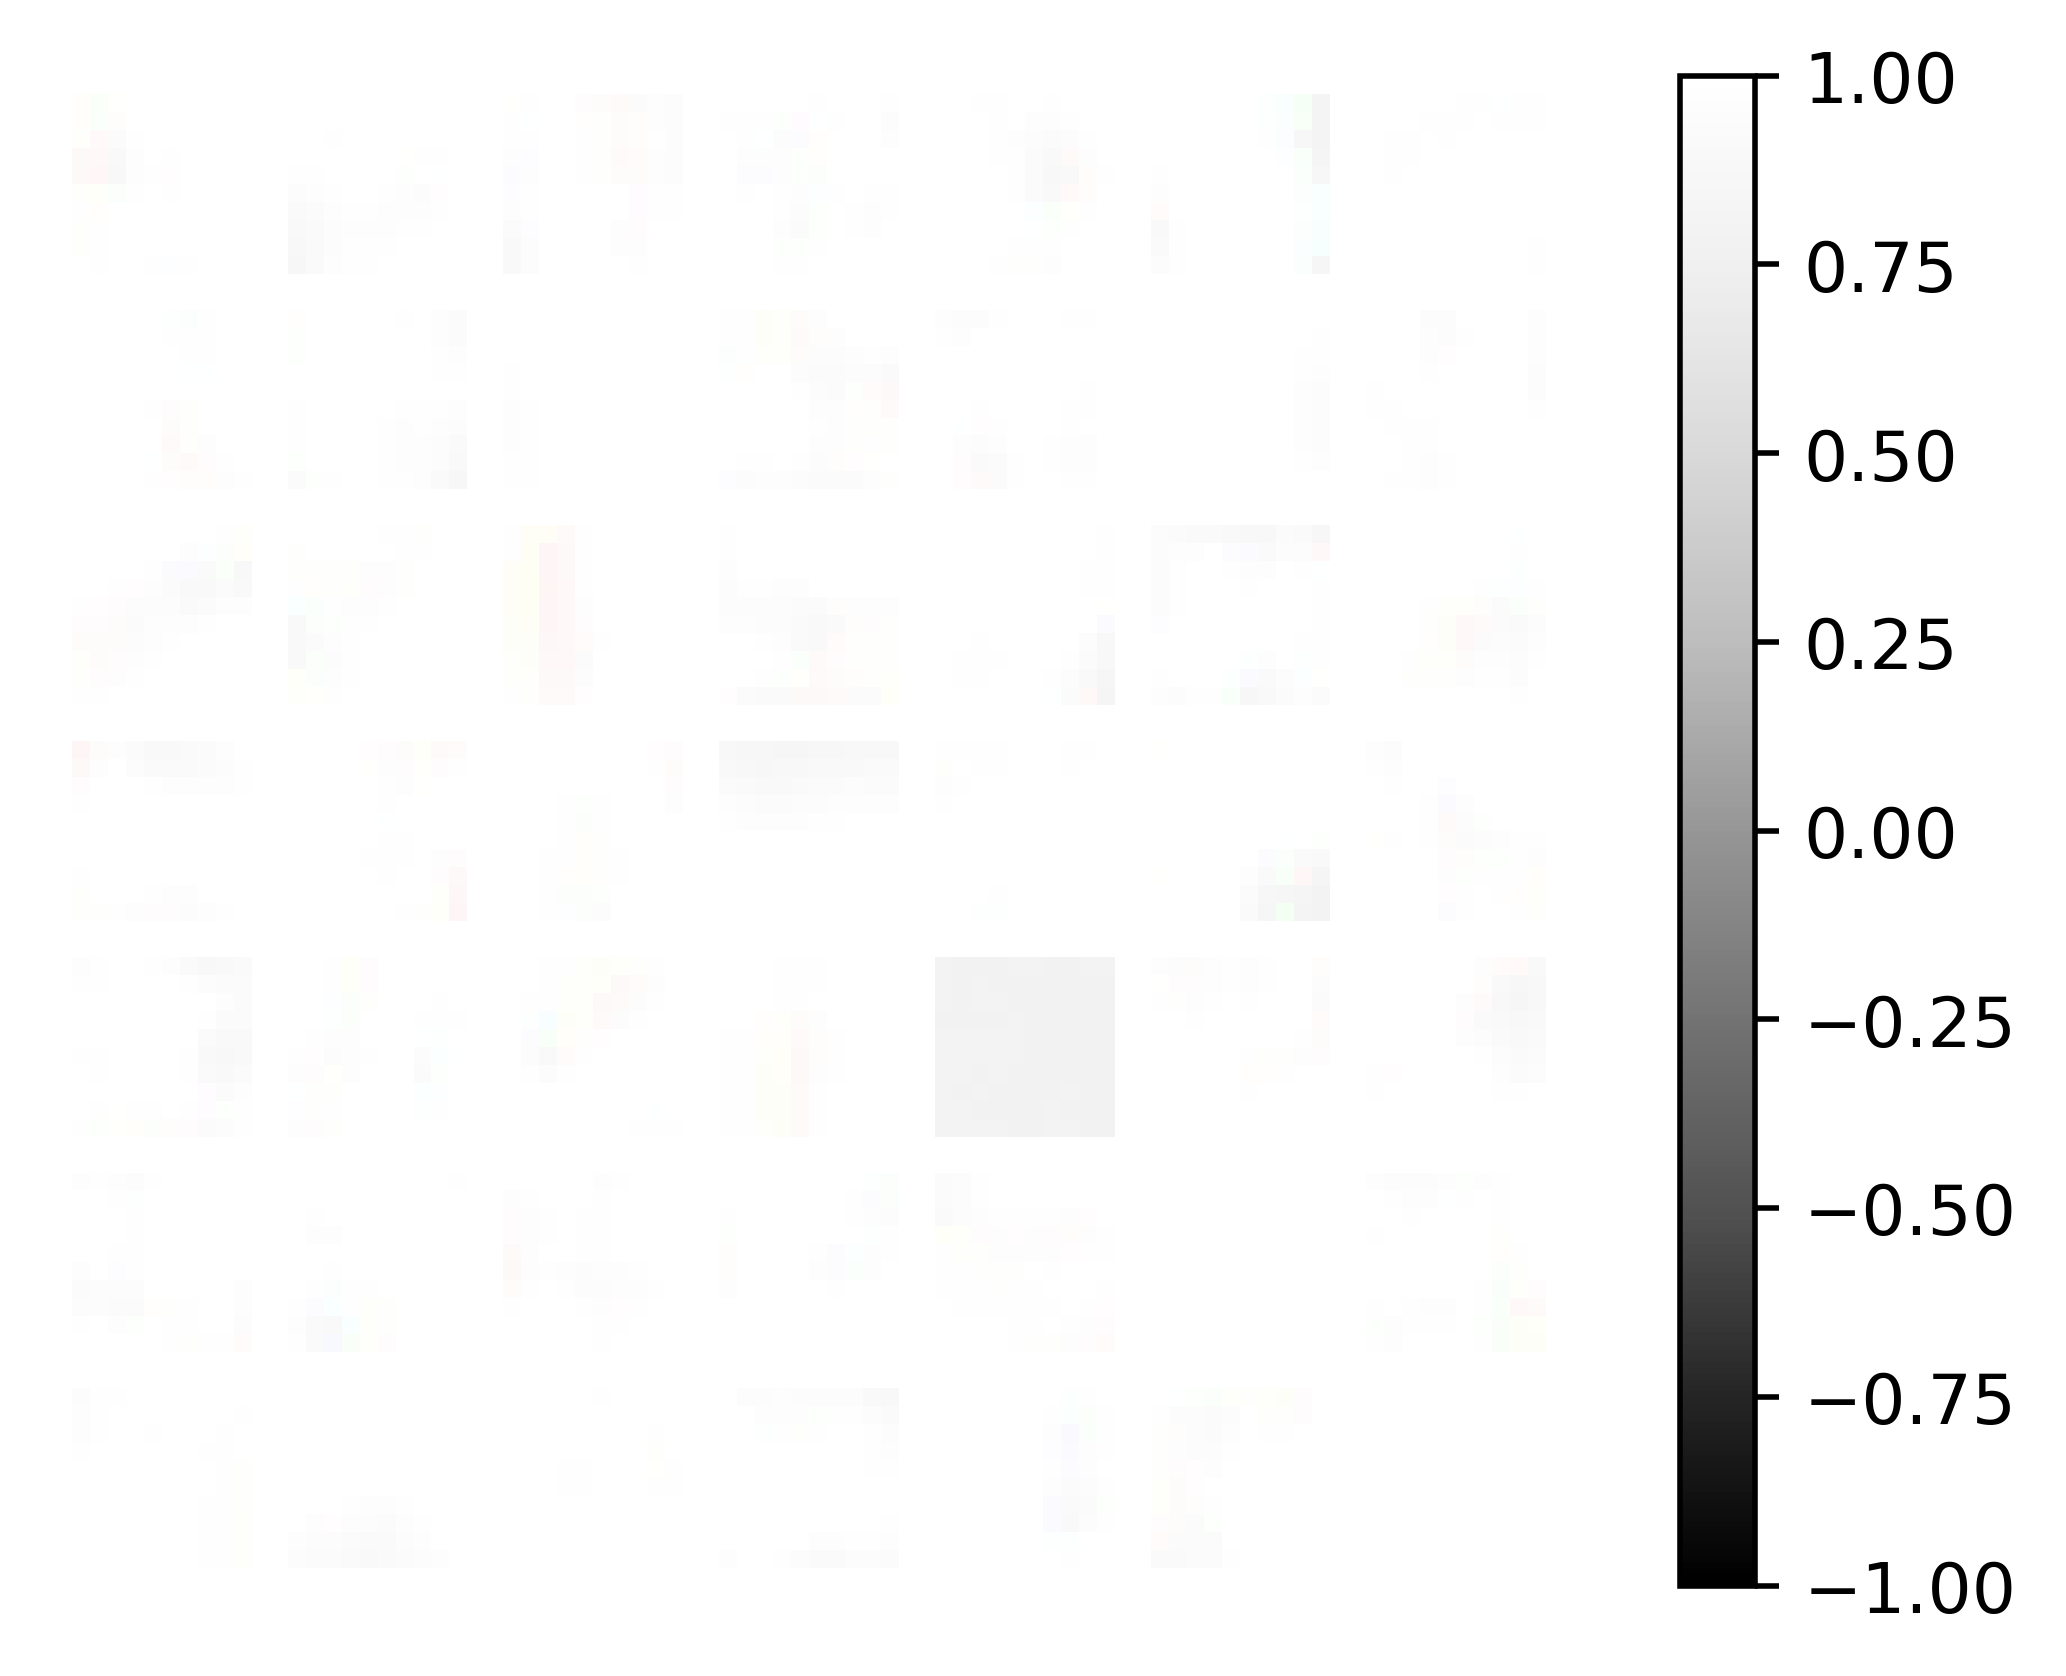

In [13]:
imp.reload(mplu)
imp.reload(plu)
#plu.plot_tiled_rfs(np.rollaxis(inweights_evolution[-1][0,:,:,:],2,0))
#mplu.plot_temporal_weights(np.rollaxis(inweights_evolution[-1][0,:,:,:],2,0))

#print(inweights_evolution.shape)
test = inweights_evolution[-1].T
test = outweights_evolution[-1]
print(test.shape)
#test = np.rollaxis(test[0,:,:,:],2,0)
plu.plot_tiled_rfs(test)
#print(test)
#mplu.plot_temporal_weights(final_outweights);
#plu.plot_tiled_rfs()

(4, 10, 10, 48)


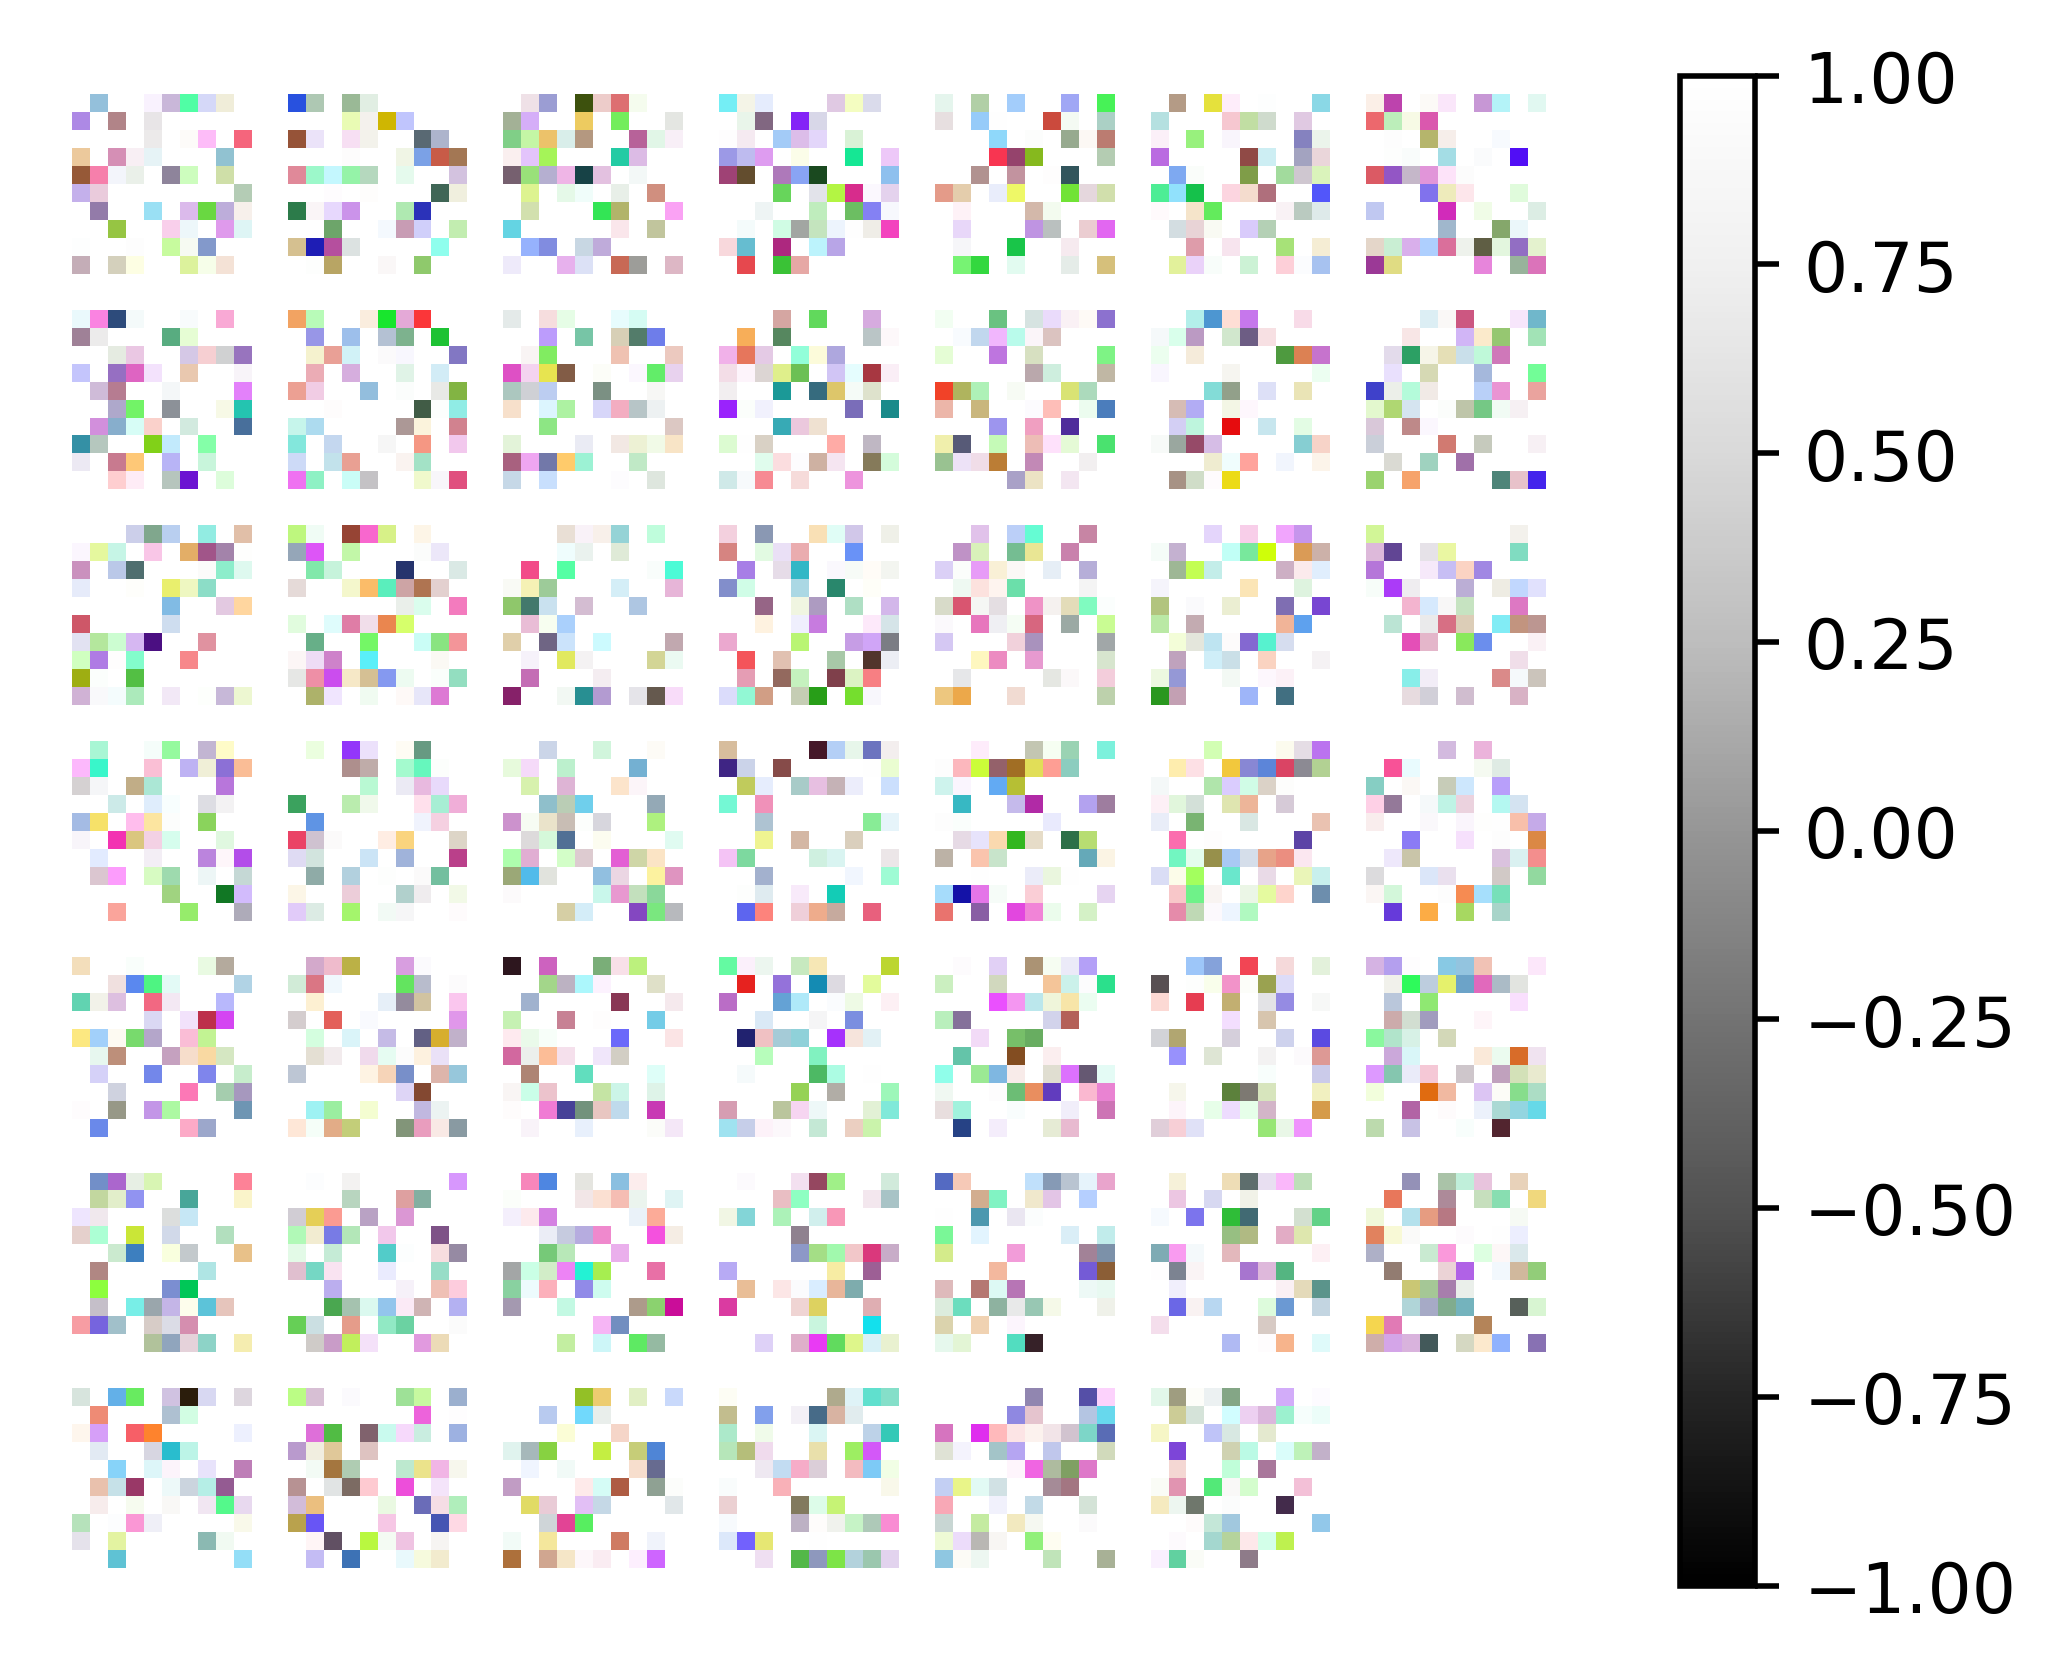

In [14]:
print(final_inweights.shape)
#print(final_outweights.shape)
plu.plot_tiled_rfs(final_inweights.T)

(4, 10, 10, 48)


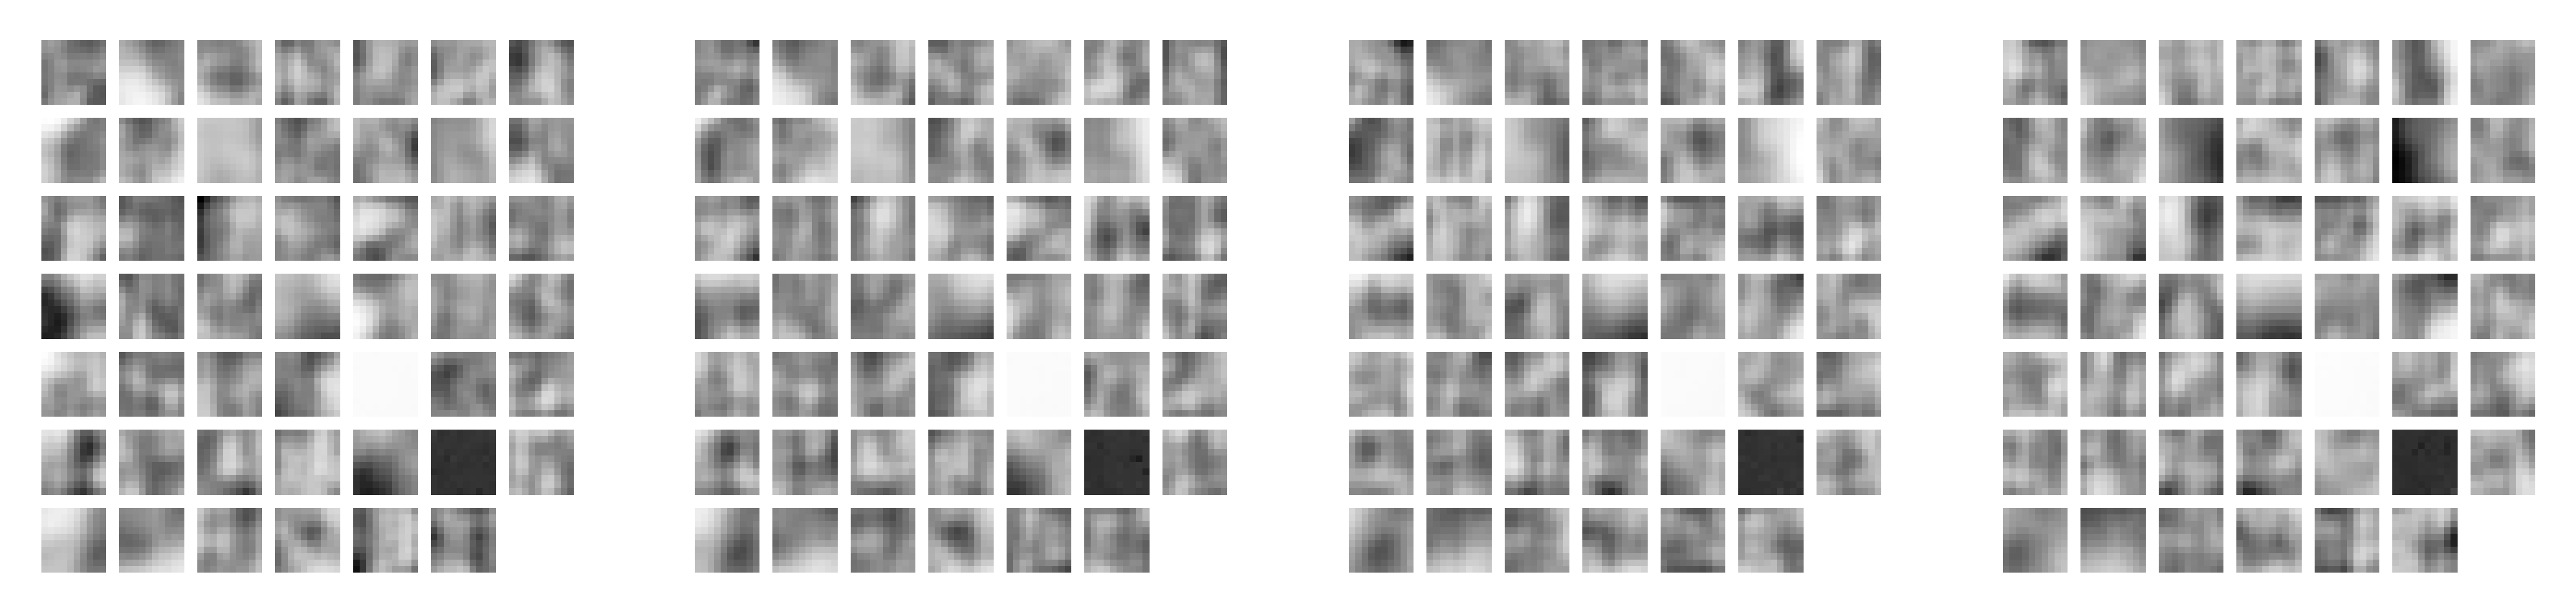

In [15]:
test = final_outweights.T
print(np.shape(test))
mplu.plot_temporal_weights(test);

(4, 10, 10, 48)


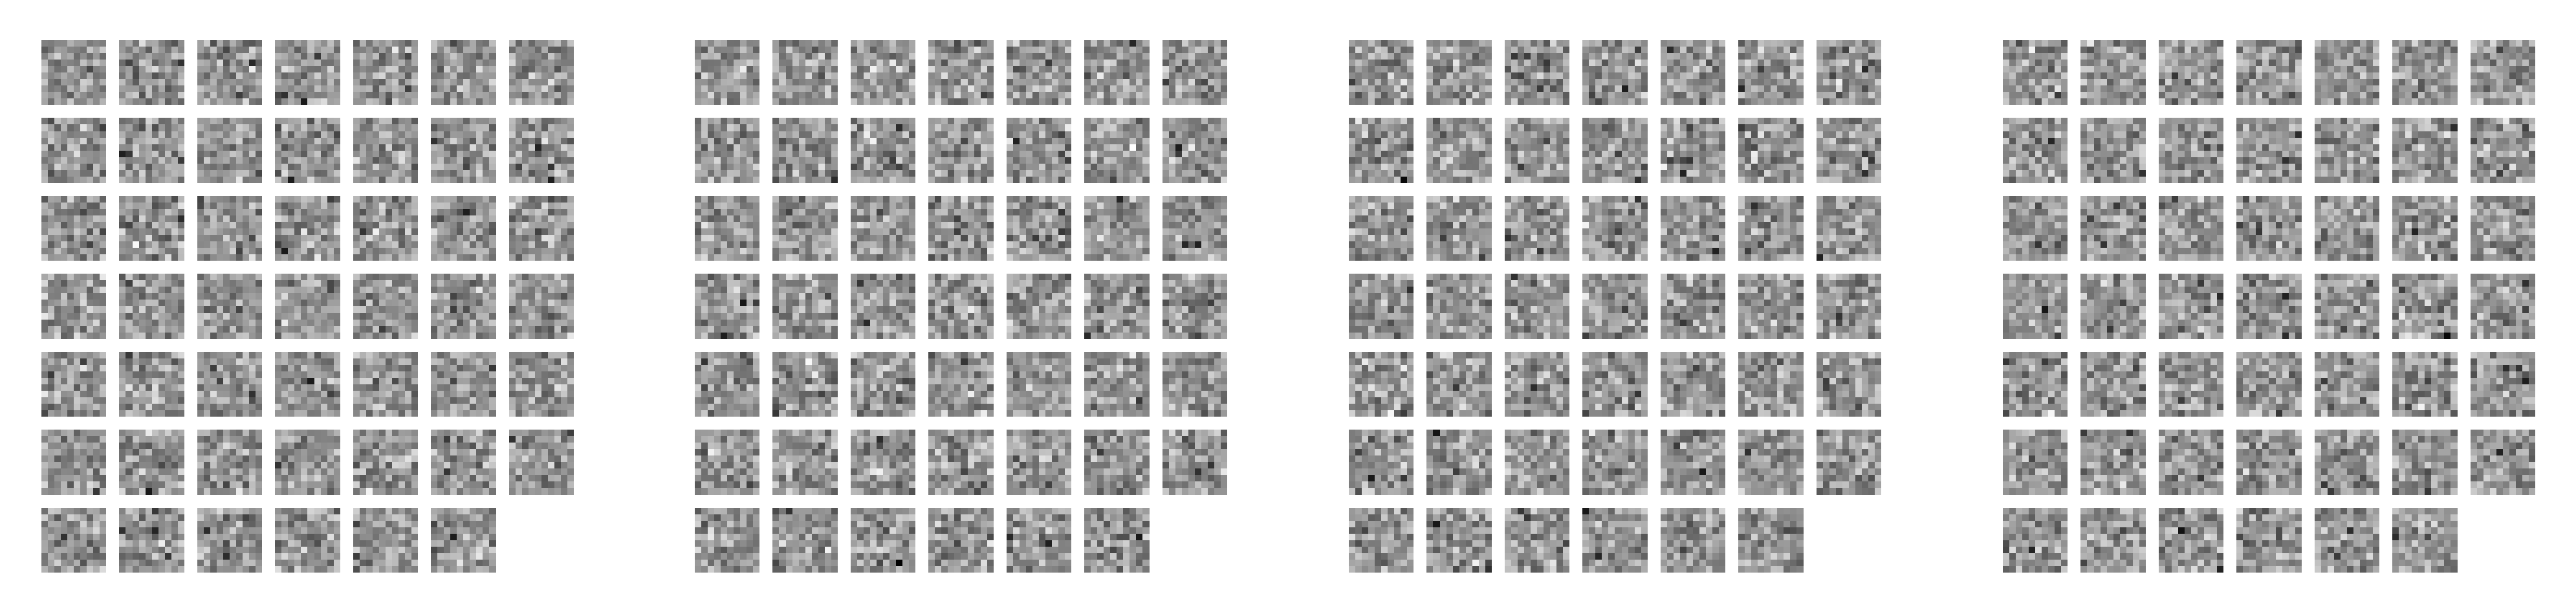

In [16]:
imp.reload(mplu)
imp.reload(plu)
print(final_inweights.shape)
#mplu.plot_temporal_weights(final_inweights);
#plu.plot_tiled_rfs(np.rollaxis(final_inweights[0,:,:,:],2,0))

#plt.figure(figsize=(10,3))
#test = np.transpose(final_inweights,axes=(0,2,1,3))
#print(test.shape)
#mplu.plot_temporal_weights(final_outweights.T);
mplu.plot_temporal_weights(final_inweights);
#plu.plot_tiled_rfs(np.rollaxis(test[0,:,:,:],2,0))


0

[MoviePy] Building file weight_movie.gif with imageio




  0%|          | 0/17 [00:00<?, ?it/s]

 12%|█▏        | 2/17 [00:00<00:00, 19.10it/s]

0
0
0


0




 24%|██▎       | 4/17 [00:00<00:00, 19.05it/s]

 35%|███▌      | 6/17 [00:00<00:00, 19.10it/s]

1
1
1


1




 47%|████▋     | 8/17 [00:00<00:00, 18.98it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 18.55it/s]

2
2
2


2




 71%|███████   | 12/17 [00:00<00:00, 13.88it/s]

3




 82%|████████▏ | 14/17 [00:00<00:00, 14.74it/s]

3
3
3




 94%|█████████▍| 16/17 [00:00<00:00, 15.32it/s]



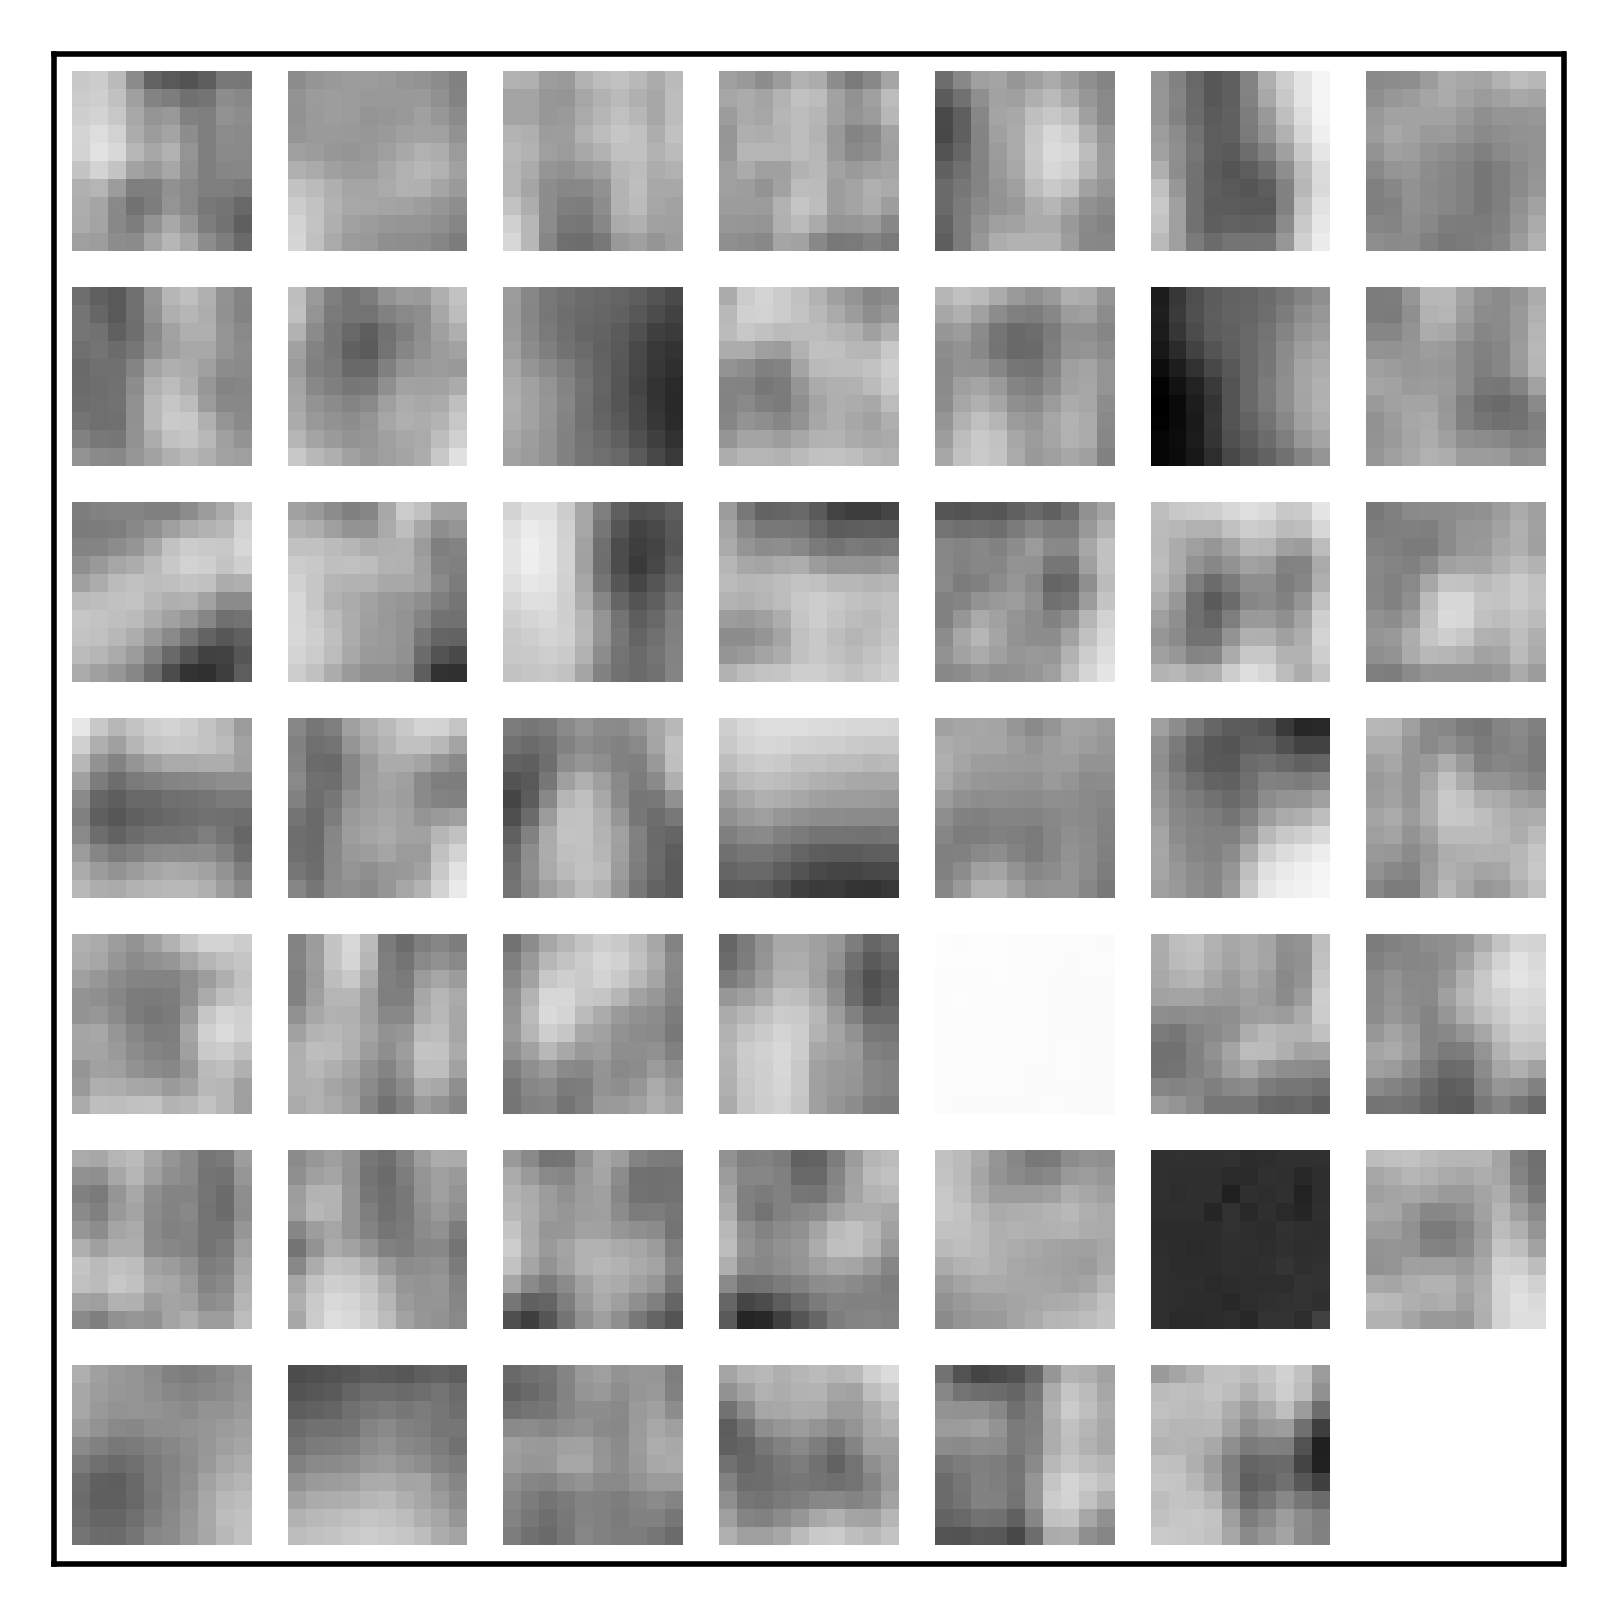

In [74]:
imp.reload(mplu)
animation = mplu.weights_movieclip(final_outweights.T);
#animation.ipython_display(fps=20, loop=True, autoplay=True)
#from IPython.display import HTML
#HTML('<img src="./weight_movie.gif>')

(10, 10, 48)


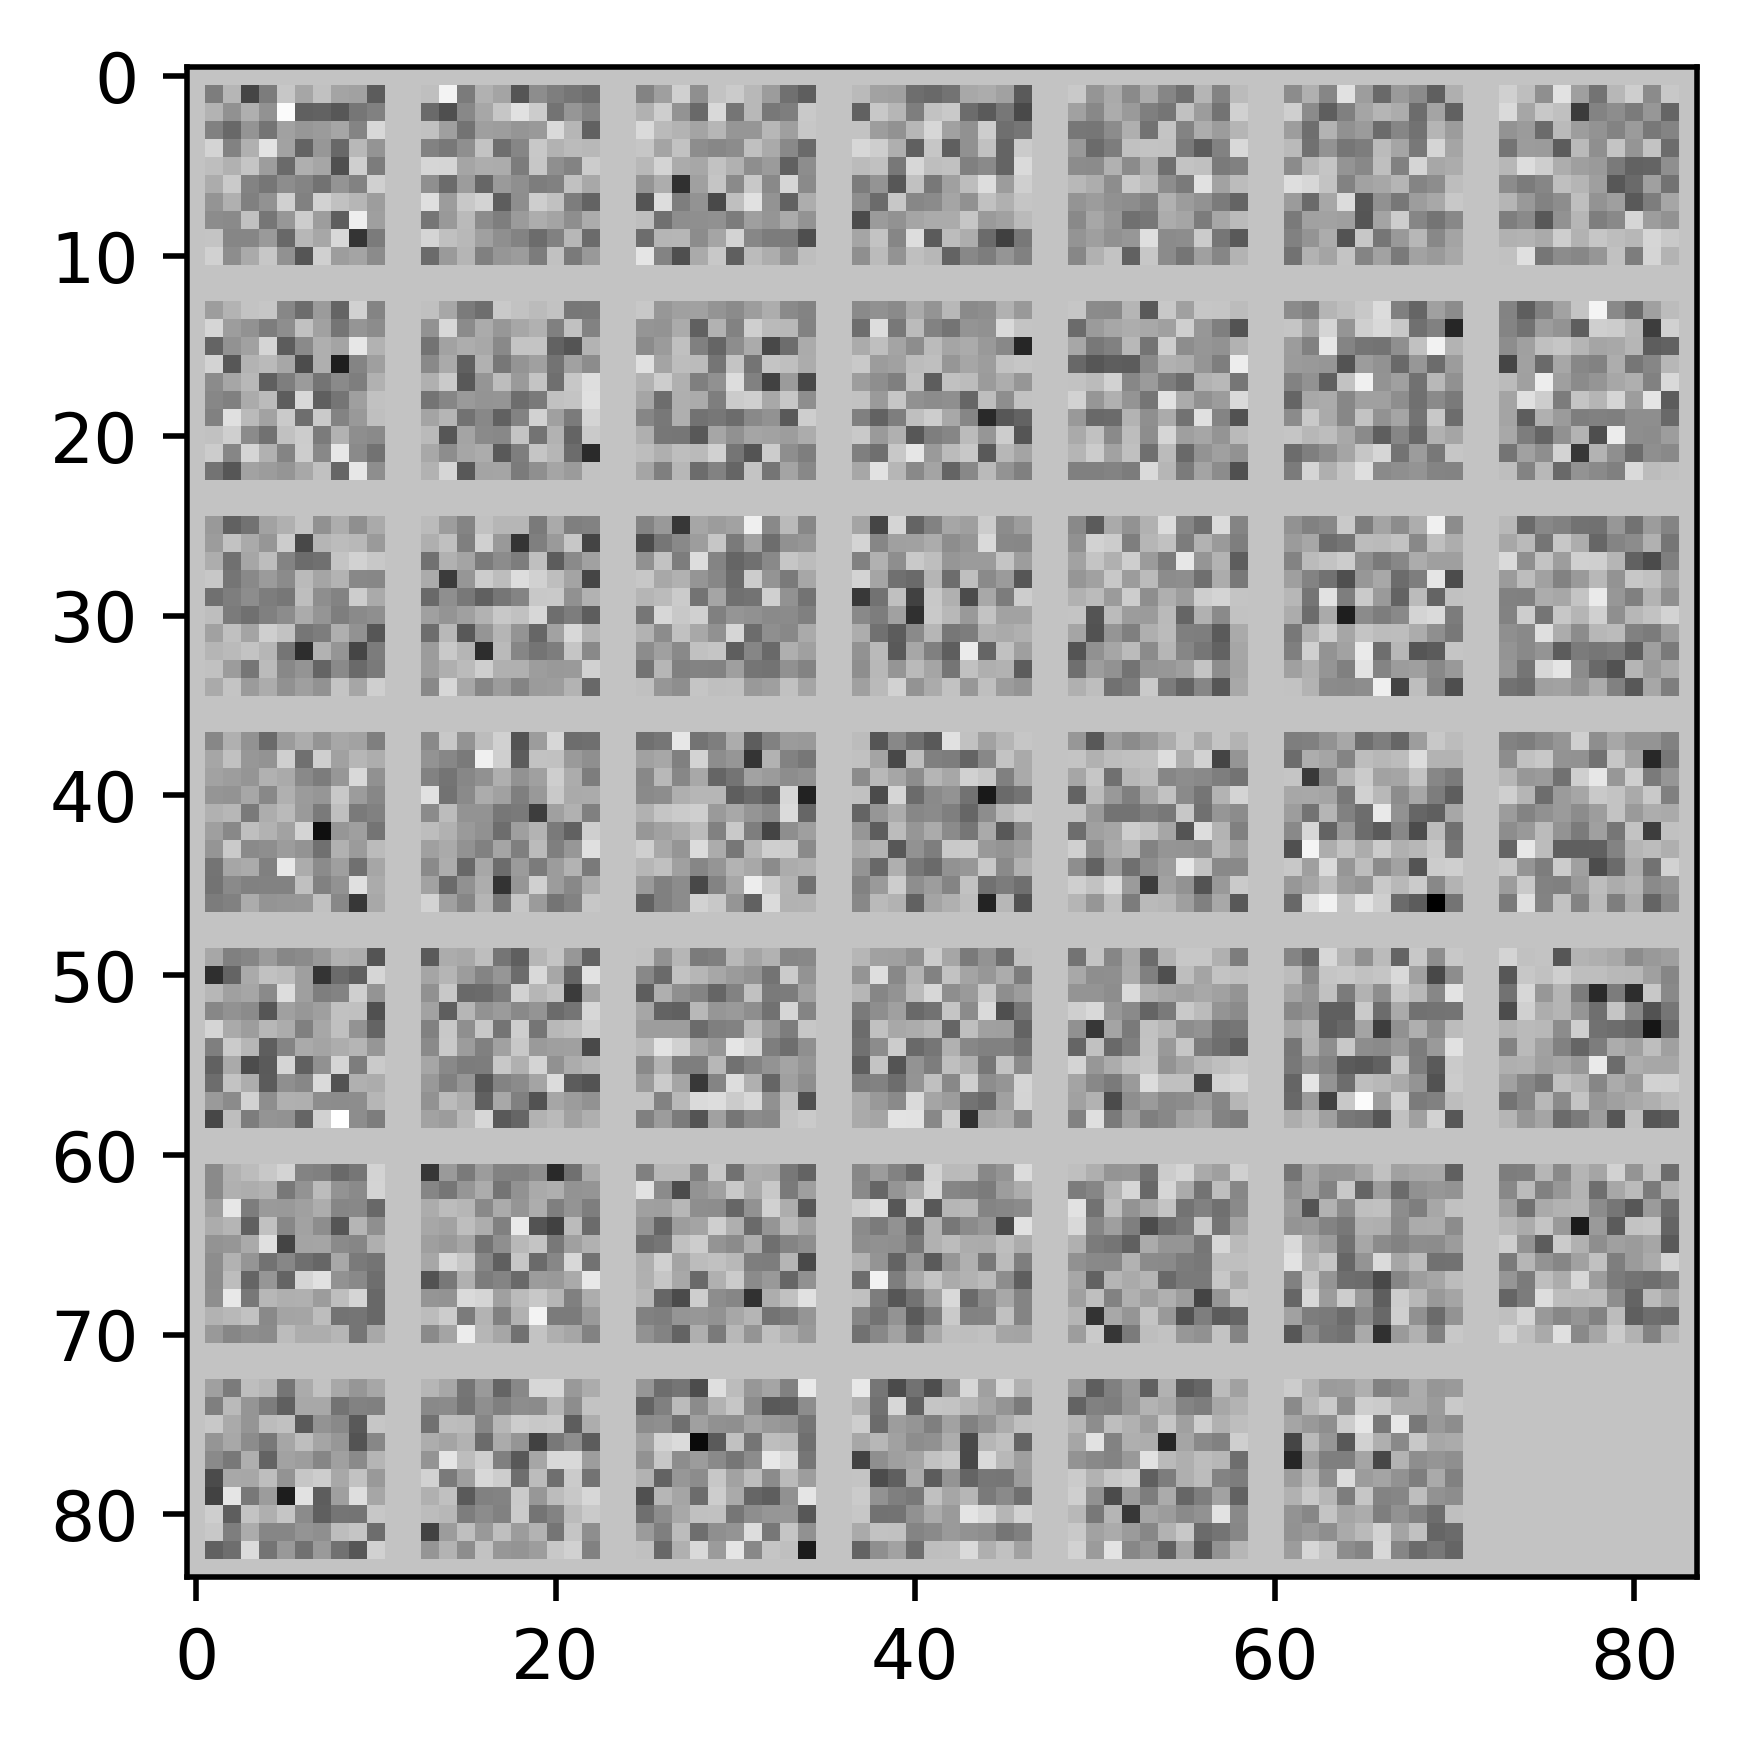

In [69]:
print(final_inweights[-1].shape)
p = plu.pad_data(final_inweights[-1].T)
plt.imshow(p,cmap='Greys_r')

In [ ]:
mplu.plot_temporal_weights(np.transpose(final_inweights,axes=(0,2,1,3)));

In [ ]:
##TWO BASIS VECTORS##
mplu.plot_mov_recon(final_outweights.T[:,:,:,8],final_outweights.T[:,:,:,20],nframes=params['frames_per_channel']);


In [ ]:
##TWO BASIS VECTORS##
mplu.plot_mov_recon(test[2,:,:,:],final_inweights[2,:,:,:],nframes=params['frames_per_channel']);


In [ ]:
#diff = final_inweights - inweights_evolution[1]
#print(diff.shape)
print(final_inweights.shape)
for i in range(final_inweights.shape[3]):
    sbplt = np.sqrt(final_inweights.shape[3])
    plt.subplot(sbplt,sbplt,i+1)
    plt.imshow(np.linalg.inv(final_outweights.T[0,:,:,i]),cmap='Greys_r')
    #plt.imshow(final_inweights[2,:,:,i],cmap='Greys_r')
    #plt.imshow(test,cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])


In [ ]:
print(final_inweights.shape)
print(final_outweights.shape)
print(np.array(recons).shape)
print(np.array(clips).shape)

In [ ]:
randomclipindex = np.random.randint(np.shape(clips[0])[0])

#print the cost of this instance
print(np.mean(np.log1p(clips[-1][randomclipindex,:,:,:] - recons[-1][randomclipindex,:,:,:])))

mplu.plot_mov_recon(clips[-1][randomclipindex,:,:,:],recons[-1][randomclipindex,:,:,:],nframes=5);

In [ ]:
plt.plot(np.log(np.mean(cost_evolution,axis=2).flatten()))

In [ ]:
##Check norm of weights
plt.plot(np.linalg.norm(final_inweights.reshape(8*64,1000), ord=2, axis=0))

In [ ]:
print(inweights_evolution[-1].T.shape)
#plu.plot_tiled_rfs(inweights_evolution[-1].T[:,:,:,0])
padded_wv = plu.pad_data(inweights_evolution[-1].T[:,:,:,0])
print(padded_wv.shape)
plt.imshow(padded_wv)

In [ ]:
import imageio
images = []

for i in range(np.shape(final_inweights)[3]):
    basisfun = plt.imshow(final_inweights[0,:,:,i],cmap='Greys_r');
    images.append(basisfun)
imageio.mimsave('test.gif', images)

In [ ]:
p = plt.errorbar(np.arange(len(cost_evolution)),
                 np.log(np.mean(np.array(cost_evolution),axis=1)),
                 yerr=np.log(np.std(np.array(cost_evolution),axis=1)));
plt.title("Log-Cost Evolution Over Iterations (Errorbar = 1SD)")

In [ ]:
np.shape(np.array(activation_evolution))

In [ ]:
p = plt.errorbar(np.arange(len(activation_evolution)),
                 np.array(activation_evolution),
                 yerr=np.std(np.array(activation_evolution),axis=0));
plt.title('Evolution of Activation over Learning')

In [ ]:
plt.imshow(recons[0][randomclipindex],cmap="Greys_r")
plt.colorbar()

In [ ]:
plt.imshow(clips[0][randomclipindex],cmap="Greys_r")
plt.colorbar()

In [ ]:

np.shape(final_inweights)

In [ ]:
np.shape(inweights_evolution)

In [ ]:
import sklearn as skl

npatches = 1000

test = m[0:npatches,:5,:,:].reshape((npatches,-1))
print(test.shape)
cov_mat = np.cov(test)
eig_val, eig_vec = np.linalg.eigh(cov_mat)
print(eig_val)
print(np.shape(eig_val))

invcovmat = eig_vec
#recon_val, recon_vec = np.linalg.eig(invcovmat)

#recon_vec

#pca = skl.decomposition.PCA()
#pca.fit(test)
#np.pca(test).shape
#pca